# Card Fraud Detection Simulator  
Exploratory Analysis and Rule Evaluation

This notebook explores synthetic card transaction data, including:
- MCC patterns  
- BIN-level behavior  
- Card-present vs card-not-present activity  
- Geo mismatch signals  
- Device patterns  
- Rule performance  
- Chargeback correlation

The goal is to walk through the dataset analytically and explain how the rule engine surfaces suspicious activity, similar to how a payments risk analyst works through fraud scenarios.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Display more columns by default
pd.set_option("display.max_columns", 50)

df = pd.read_csv("../data/card_transactions_scored.csv")
alerts = pd.read_csv("../data/card_alerts.csv")

df.head()


,transaction_id,card_id,bin,brand,card_type,home_country,merchant_id,mcc,merchant_country,amount,currency,card_present,timestamp,device_id,ip_country,ip_address,auth_result,is_fraud_pattern,fraud_scenario,chargeback,device_unique_cards,small_cnp_tx_count,risk_score,triggered_rules
0,tx_1,card_1179,400000,Visa,credit,AU,m_217,4816,US,222.67,USD,False,2025-11-13 02:52:41.680621,device_3756,AU,101.43.48.68,declined,0,NaN,0,1,0,0,NaN
1,tx_2,card_783,510000,Mastercard,credit,MX,m_127,5411,US,21.64,USD,False,2025-11-15 05:48:50.680621,device_614,MX,101.31.222.66,approved,0,NaN,0,2,0,0,NaN
2,tx_3,card_463,510000,Mastercard,credit,DE,m_60,5999,CA,183.99,USD,True,2025-11-02 07:03:42.680621,device_2581,DE,51.201.167.162,approved,0,NaN,0,4,0,0,NaN
3,tx_4,card_326,370000,Amex,credit,GB,m_43,4814,BR,156.77,USD,False,2025-10-30 15:15:45.680621,device_612,GB,51.69.55.79,approved,0,NaN,0,3,0,0,NaN
4,tx_5,card_4,400100,Visa,debit,CA,m_221,7995,BR,746.05,USD,False,2025-10-18 05:06:33.680621,device_1347,CA,23.61.183.106,approved,0,NaN,0,4,0,25,high_amount_cnp


In [2]:
df.info()
print("\nShape:", df.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transaction_id       15000 non-null  object 
 1   card_id              15000 non-null  object 
 2   bin                  15000 non-null  int64  
 3   brand                15000 non-null  object 
 4   card_type            15000 non-null  object 
 5   home_country         15000 non-null  object 
 6   merchant_id          15000 non-null  object 
 7   mcc                  15000 non-null  int64  
 8   merchant_country     15000 non-null  object 
 9   amount               15000 non-null  float64
 10  currency             15000 non-null  object 
 11  card_present         15000 non-null  bool   
 12  timestamp            15000 non-null  object 
 13  device_id            15000 non-null  object 
 14  ip_country           15000 non-null  object 
 15  ip_address           15000 non-null 

In [3]:
df.describe()


,bin,mcc,amount,is_fraud_pattern,chargeback,device_unique_cards,small_cnp_tx_count,risk_score
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,447261.120000,5821.901333,263.082783,0.026867,0.008067,3.993800,0.118600,9.896667
std,64766.256849,867.089272,237.820336,0.161699,0.089455,1.721615,0.342357,12.410597
min,370000.000000,4814.000000,1.490000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,400000.000000,5411.000000,88.295000,0.000000,0.000000,3.000000,0.000000,0.000000
50%,400100.000000,5968.000000,191.790000,0.000000,0.000000,4.000000,0.000000,0.000000
75%,520000.000000,6011.000000,317.015000,0.000000,0.000000,5.000000,0.000000,15.000000
max,530000.000000,7995.000000,999.360000,1.000000,1.000000,10.000000,3.000000,70.000000


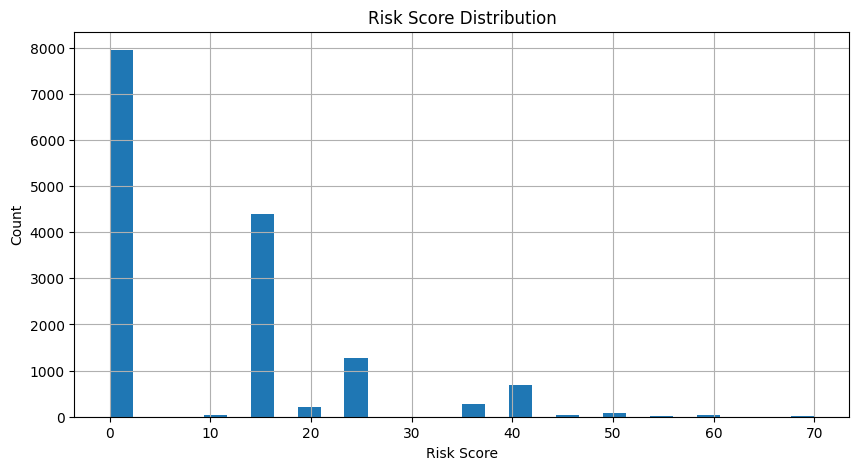

In [4]:
plt.figure(figsize=(10,5))
plt.hist(df['risk_score'], bins=30)
plt.title("Risk Score Distribution")
plt.xlabel("Risk Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [5]:
df['risk_bucket'] = pd.cut(
    df['risk_score'],
    bins=[-1, 0, 20, 40, 100],
    labels=["0", "1-20", "21-40", "41+"]
)

df['risk_bucket'].value_counts().sort_index()


risk_bucket
0        7947
1-20     4645
21-40    2239
41+       169
Name: count, dtype: int64

In [6]:
mcc_summary = df.groupby("mcc").agg(
    total_tx=("transaction_id", "count"),
    fraud=("is_fraud_pattern", "sum"),
    avg_risk=("risk_score", "mean")
).sort_values(by="avg_risk", ascending=False)

mcc_summary


,total_tx,fraud,avg_risk
mcc,,,
6051,1872,172,20.008013
7995,1507,134,19.061048
5732,2128,41,12.135808
5968,1263,37,6.167854
4816,1766,19,6.002265
5999,1414,0,6.000707
4814,1837,0,5.914535
5411,1545,0,5.834951
6011,1668,0,5.809353


In [7]:
bin_summary = df.groupby("bin").agg(
    total_tx=("transaction_id", "count"),
    fraud=("is_fraud_pattern", "sum"),
    avg_amount=("amount", "mean"),
    avg_risk=("risk_score", "mean")
).sort_values("avg_risk", ascending=False)

bin_summary


,total_tx,fraud,avg_amount,avg_risk
bin,,,,
400100,2768,75,263.690993,10.261922
510000,2878,57,263.125382,10.029534
400000,2581,67,262.442487,10.023247
520000,2683,59,267.126571,9.787551
370000,2885,57,261.017244,9.559792
530000,1205,88,258.896954,9.518672


In [8]:
geo_mismatch = df[df['ip_country'] != df['home_country']]

print("Geo mismatch rate:", len(geo_mismatch) / len(df))

geo_mismatch.head(10)


Geo mismatch rate: 0.0408


,transaction_id,card_id,bin,brand,card_type,home_country,merchant_id,mcc,merchant_country,amount,currency,card_present,timestamp,device_id,ip_country,ip_address,auth_result,is_fraud_pattern,fraud_scenario,chargeback,device_unique_cards,small_cnp_tx_count,risk_score,triggered_rules,risk_bucket
9,tx_10,card_54,370000,Amex,credit,CA,m_91,4816,DE,65.56,USD,False,2025-10-17 20:22:12.680621,device_1146,US,23.66.101.205,approved,1,geo_mismatch_cnp_high_risk_mcc,0,4,0,20,geo_mismatch_cnp,1-20
24,tx_25,card_154,400100,Visa,debit,DE,m_193,5968,BR,137.33,USD,False,2025-11-09 03:54:18.680621,device_1651,MX,101.165.30.11,approved,1,geo_mismatch_cnp_high_risk_mcc,0,5,0,35,"geo_mismatch_cnp,shared_device_many_cards",21-40
68,tx_69,card_896,400100,Visa,debit,AU,m_103,5968,DE,233.58,USD,False,2025-10-24 18:29:44.680621,device_4925,MX,101.156.140.216,approved,1,geo_mismatch_cnp_high_risk_mcc,1,5,0,35,"geo_mismatch_cnp,shared_device_many_cards",21-40
83,tx_84,card_746,520000,Mastercard,debit,MX,m_230,6051,DE,238.68,USD,False,2025-10-08 09:53:31.680621,device_3704,GB,51.81.250.45,approved,1,geo_mismatch_cnp_high_risk_mcc,0,4,0,20,geo_mismatch_cnp,1-20
101,tx_102,card_1078,510000,Mastercard,credit,MX,m_241,4816,AU,16.24,USD,False,2025-11-05 03:58:46.680621,device_2951,BR,101.59.48.23,approved,0,NaN,0,5,0,35,"geo_mismatch_cnp,shared_device_many_cards",21-40
141,tx_142,card_837,400100,Visa,debit,AU,m_228,7995,US,351.05,USD,False,2025-10-16 21:09:27.680621,device_2863,CA,23.169.184.150,approved,0,NaN,0,3,0,20,geo_mismatch_cnp,1-20
152,tx_153,card_657,520000,Mastercard,debit,US,m_83,4816,DE,217.27,USD,False,2025-11-05 02:16:37.680621,device_2469,AU,101.202.15.242,declined,1,geo_mismatch_cnp_high_risk_mcc,0,5,0,35,"geo_mismatch_cnp,shared_device_many_cards",21-40
171,tx_172,card_1006,400000,Visa,credit,MX,m_227,4814,FR,81.00,USD,True,2025-10-12 02:39:35.680621,device_1694,DE,51.184.198.240,approved,0,NaN,0,4,0,0,NaN,0
207,tx_208,card_464,370000,Amex,credit,BR,m_84,4814,MX,160.39,USD,False,2025-12-01 04:36:46.680621,device_593,DE,51.59.131.128,approved,0,NaN,0,2,0,20,geo_mismatch_cnp,1-20
281,tx_282,card_603,520000,Mastercard,debit,DE,m_212,4814,AU,294.56,USD,False,2025-11-18 18:15:06.680621,device_2650,AU,101.109.192.130,approved,0,NaN,0,5,0,35,"geo_mismatch_cnp,shared_device_many_cards",21-40


In [9]:
device_summary = df.groupby("device_id").agg(
    unique_cards=("card_id", "nunique"),
    total_tx=("transaction_id", "count"),
    avg_risk=("risk_score", "mean")
).sort_values("unique_cards", ascending=False)

device_summary.head(15)


,unique_cards,total_tx,avg_risk
device_id,,,
device_4945,10,10,22.500000
device_4732,10,10,23.500000
device_275,10,10,20.000000
device_3461,10,10,22.500000
device_299,9,9,17.222222
device_3970,9,9,24.444444
device_3183,9,9,22.777778
device_1883,9,9,24.444444
device_1785,9,9,22.777778


In [10]:
alerts['rule_name'].value_counts()


rule_name
shared_device_many_cards    5358
high_amount_cnp             2244
geo_mismatch_cnp             462
declined_high_amount         274
Name: count, dtype: int64

In [11]:
rule_precision = alerts.merge(
    df[['transaction_id','is_fraud_pattern']],
    on='transaction_id'
)

rule_precision.groupby("rule_name")['is_fraud_pattern'].mean().sort_values(ascending=False)


rule_name
declined_high_amount        0.492701
geo_mismatch_cnp            0.199134
high_amount_cnp             0.131016
shared_device_many_cards    0.029302
Name: is_fraud_pattern, dtype: float64

In [14]:
df.groupby("risk_bucket", observed=False)['chargeback'].mean().sort_values(ascending=False)



risk_bucket
41+      0.112426
21-40    0.034390
1-20     0.004090
0        0.000755
Name: chargeback, dtype: float64

# Summary

Key findings from this synthetic dataset:

- High risk MCCs such as betting, quasi-cash, and direct marketing have elevated fraud rates.
- Prepaid BINs show higher average risk scores.
- Geo mismatches combined with CNP behavior map closely to injected fraud scenarios.
- Devices used by many cards tend to have higher average risk.
- Rule precision varies, but several rules align strongly with the synthetic fraud labels.
- Risk bucket distributions show that the rule engine meaningfully separates low-risk and high-risk transactions.

This workflow mirrors the type of reasoning expected in payments risk roles, where analysts must connect MCCs, BINs, CNP behavior, device signals, and fraud labels into a clear narrative.
